# Installing Libraries

In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from langdetect import detect
from googletrans import Translator
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import pickle
from tqdm import tqdm
import time
from gensim.models import LdaMulticore

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/karthikeyana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karthikeyana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/karthikeyana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Pre-processing

In [2]:
# Initialize the spell checker and translator
spell = SpellChecker()
translator = Translator()

In [3]:
# Load the data
file_path = '/Users/karthikeyana/Desktop/Trimester IV/NLP/NLP Project/Reviews.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,review,score
0,I have gotten more likes on here than other a...,3
1,- (11/16/22) why are we here - (11/30/22) I th...,2
2,"- 0 rate - On the website, it says if u delete...",1
3,- 3 stars already for the fact i just got on i...,2
4,- A minha conta simplesmente foi banida sem eu...,1


In [5]:
# Assuming the column with reviews is named 'review'
reviews = df['review']

## Data Cleaning

In [6]:
# Define a function for converting Hindi slangs to English words
def convert_hindi_slangs(text):
    hindi_slangs = {
        "accha": "good",
        "kya": "what",
        "hai": "is",
        "nahi": "no",
        "kaise": "how",
        "haan": "yes",
        # Add more as needed
    }
    for hindi, english in hindi_slangs.items():
        text = re.sub(r'\b' + hindi + r'\b', english, text)
    return text

# Define a function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # Convert Hindi slangs to English
    text = convert_hindi_slangs(text)
    return text

# Function to correct spelling
def correct_spelling(text):
    if pd.isnull(text):
        return text
    corrected_text = []
    for word in text.split():
        corrected_word = spell.correction(word)
        if corrected_word:
            corrected_text.append(corrected_word)
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)

In [12]:
# Clean the reviews
df['cleaned_reviews'] = df['review'].apply(clean_text)

In [ ]:
# Correct spelling in reviews with checkpoints
chunk_size = 500
for start in tqdm(range(0, len(df), chunk_size), desc="Spell Checking"):
    end = start + chunk_size
    df.loc[start:end, 'corrected_reviews'] = df.loc[start:end, 'cleaned_reviews'].apply(correct_spelling)
    print(f"Processed up to review {end}")

Spell Checking:   0%|                        | 1/201 [01:51<6:13:09, 111.95s/it]

Processed up to review 500


Spell Checking:   1%|▏                       | 2/201 [05:10<9:00:39, 163.01s/it]

Processed up to review 1000


Spell Checking:   1%|▎                       | 3/201 [07:46<8:46:33, 159.56s/it]

Processed up to review 1500


Spell Checking:   2%|▍                      | 4/201 [13:21<12:31:42, 228.95s/it]

Processed up to review 2000


Spell Checking:   2%|▌                       | 5/201 [14:58<9:52:00, 181.23s/it]

Processed up to review 2500


Spell Checking:   3%|▋                       | 6/201 [16:47<8:29:33, 156.79s/it]

Processed up to review 3000


Spell Checking:   3%|▊                       | 7/201 [18:21<7:21:08, 136.44s/it]

Processed up to review 3500


In [ ]:
# Define a function for tokenizing and removing stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [ ]:
# Tokenize and remove stopwords
tokenized_reviews = corrected_reviews.apply(tokenize_and_remove_stopwords)

# Define a function for lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Lemmatize the tokens
processed_tokens = tokenized_reviews.apply(lemmatize_tokens)

In [ ]:
# Save preprocessed data
df['cleaned_review'] = processed_tokens.apply(lambda x: ' '.join(x))
df.to_csv('/Users/karthikeyana/Desktop/Trimester IV/NLP/NLP Project/preprocessed_reviews.csv', index=False)

print("Data cleaning and preprocessing complete. Data saved to 'preprocessed_reviews.csv'.")

## Optimal Number of Topics

In [ ]:
#**Finding Optimal Number of Topic**

In [2]:
# Load the preprocessed data
df = pd.read_csv('/Users/karthikeyana/Desktop/Trimester IV/NLP/NLP Project/preprocessed_reviews.csv')

In [3]:
df.head()

,review,score,cleaned_reviews,corrected_reviews,cleaned_review
0,I have gotten more likes on here than other a...,3,i have gotten more likes on here than other a...,i have gotten more likes on here than other ap...,gotten like app compatibility rating allows mu...
1,- (11/16/22) why are we here - (11/30/22) I th...,2,why are we here i threw money at the probl...,why are we here i threw money at the problem s...,threw money problem starting see steady progre...
2,"- 0 rate - On the website, it says if u delete...",1,rate on the website it says if u delete acc...,rate on the website it says if u delete accoun...,rate website say u delete account make new one...
3,- 3 stars already for the fact i just got on i...,2,stars already for the fact i just got on it ...,stars already for the fact i just got on it an...,star already fact got already getting fake not...
4,- A minha conta simplesmente foi banida sem eu...,1,a minha conta simplesmente foi banida sem eu ...,a mina conga simplesmente for band see e new h...,mina conga simplesmente band see e new posted ...


In [4]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Ensure NLTK tokenizer is downloaded
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/karthikeyana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Define the irrelevant words
irrelevant_words = {'cant', 'not', 'phone', 'please', 'even', 'keep', 'log', 'get', 'lot', 'many', 'de','na','hi','ya','u','e','really','la','et'}

# Convert the cleaned reviews to a list of tokens and filter out irrelevant words
data = df['cleaned_review'].astype(str).apply(word_tokenize).tolist()
filtered_data = [[word for word in text if word not in irrelevant_words] for text in data]

# Create a dictionary and corpus from the filtered data
dictionary = corpora.Dictionary(filtered_data)
corpus = [dictionary.doc2bow(text) for text in filtered_data]



In [6]:
# Function to compute coherence values with reduced chunk size and progress tracking
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=20, step=1):
    coherence_values = []
    model_list = []
    num_models = (limit - start) // step
    for i, num_topics in enumerate(range(start, limit, step)):
        start_time = time.time()  # Start timing
        print(f"Processing model {i+1}/{num_models} with {num_topics} topics...")
        
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=400,  # Reduced chunk size
                                           passes=4,
                                           per_word_topics=True,
                                           workers=6)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
        
        # Calculate and display the percentage completed
        percentage_completed = ((i + 1) / num_models) * 100
        print(f"Completed: {percentage_completed:.2f}%")
        
        end_time = time.time()  # End timing
        print(f"Completed in {end_time - start_time:.2f} seconds.")
        
    return model_list, coherence_values

In [15]:
# Compute coherence scores
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data)

Processing model 1/18 with 2 topics...
Completed: 5.56%
Completed in 36.90 seconds.
Processing model 2/18 with 3 topics...
Completed: 11.11%
Completed in 37.02 seconds.
Processing model 3/18 with 4 topics...
Completed: 16.67%
Completed in 43.69 seconds.
Processing model 4/18 with 5 topics...
Completed: 22.22%
Completed in 44.53 seconds.
Processing model 5/18 with 6 topics...
Completed: 27.78%
Completed in 45.06 seconds.
Processing model 6/18 with 7 topics...
Completed: 33.33%
Completed in 41.40 seconds.
Processing model 7/18 with 8 topics...
Completed: 38.89%
Completed in 41.95 seconds.
Processing model 8/18 with 9 topics...
Completed: 44.44%
Completed in 41.76 seconds.
Processing model 9/18 with 10 topics...
Completed: 50.00%
Completed in 42.64 seconds.
Processing model 10/18 with 11 topics...
Completed: 55.56%
Completed in 43.98 seconds.
Processing model 11/18 with 12 topics...
Completed: 61.11%
Completed in 43.28 seconds.
Processing model 12/18 with 13 topics...
Completed: 66.67%
Co

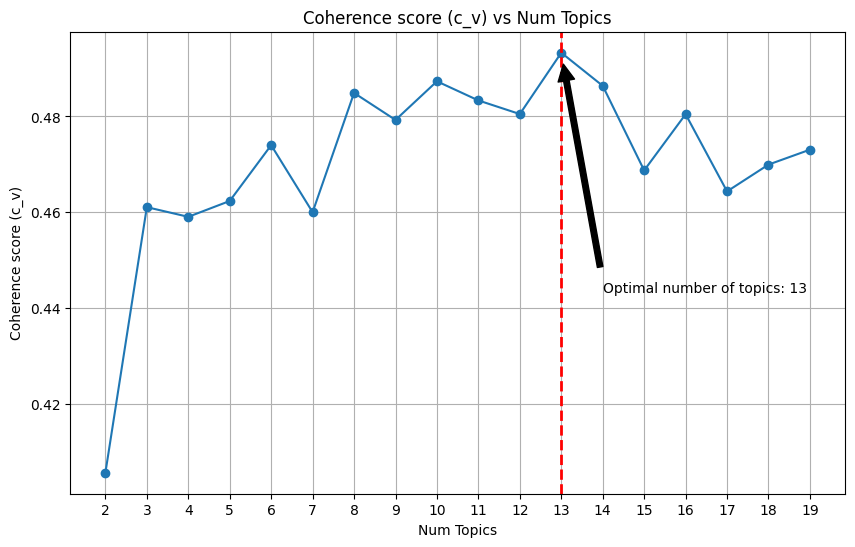

In [25]:
import matplotlib.pyplot as plt

# Assuming the range for x is set correctly for integer values of topics
x = list(range(2, 20, 1))

# Find the number of topics with the highest coherence score
optimal_num_topics = x[coherence_values.index(max(coherence_values))]

# Plotting coherence values
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.xticks(x)  # Set x-axis to show integer values for number of topics
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (c_v)")
plt.title("Coherence score (c_v) vs Num Topics")

# Highlight the spike
plt.axvline(x=optimal_num_topics, color='r', linestyle='--', linewidth=2)
plt.annotate(f'Optimal number of topics: {optimal_num_topics}', 
             xy=(optimal_num_topics, max(coherence_values)), 
             xytext=(optimal_num_topics + 1, max(coherence_values) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.grid(True)
plt.show()

In [ ]:
# Find the number of topics with the highest c_v coherence score
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

In [54]:
optimal_num_topics = 13

In [9]:
from gensim.models import CoherenceModel
from tqdm import tqdm  # For progress tracking

def compute_coherence_values(dictionary, corpus, texts, start=2, limit=20, step=1):
    coherence_values_cv = []
    coherence_values_uci = []
    coherence_values_npmi = []
    coherence_values_w2v = []
    coherence_values_umass = []  # Added for U_Mass
    model_list = []
    
    for num_topics in tqdm(range(start, limit, step), desc="Computing coherence values", unit="topic"):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=400,
                                           passes=4,
                                           per_word_topics=True,
                                           workers=6)
        model_list.append(model)
        
        coherencemodel_cv = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_cv.append(coherencemodel_cv.get_coherence())
        
        coherencemodel_uci = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_uci')
        coherence_values_uci.append(coherencemodel_uci.get_coherence())
        
        coherencemodel_npmi = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi')
        coherence_values_npmi.append(coherencemodel_npmi.get_coherence())
        
        coherencemodel_w2v = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_w2v')
        coherence_values_w2v.append(coherencemodel_w2v.get_coherence())
        
        coherencemodel_umass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')  # Added for U_Mass
        coherence_values_umass.append(coherencemodel_umass.get_coherence())
        
        print(f'Number of topics: {num_topics}, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): {coherencemodel_cv.get_coherence()}, {coherencemodel_uci.get_coherence()}, {coherencemodel_npmi.get_coherence()}, {coherencemodel_w2v.get_coherence()}, {coherencemodel_umass.get_coherence()}')
    
    return model_list, coherence_values_cv, coherence_values_uci, coherence_values_npmi, coherence_values_w2v, coherence_values_umass

# Compute coherence scores
model_list, coherence_values_cv, coherence_values_uci, coherence_values_npmi, coherence_values_w2v, coherence_values_umass = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data, start=2, limit=20, step=1)

Computing coherence values:   6%|▋            | 1/18 [00:38<10:53, 38.47s/topic]

Number of topics: 2, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4308899492180812, -0.0073945036440807126, 0.0005234313444002847, 0.7672425508499146, -2.2561028892055917


Computing coherence values:  11%|█▍           | 2/18 [01:19<10:40, 40.01s/topic]

Number of topics: 3, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.45508573597349894, 0.03547869295994796, 0.0070203739542071585, 0.7723837494850159, -2.26136638424598


Computing coherence values:  17%|██▏          | 3/18 [02:00<10:06, 40.41s/topic]

Number of topics: 4, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.46570726181540756, 0.0855782295114883, 0.014798878879321244, 0.7677671313285828, -2.4091288290428396


Computing coherence values:  22%|██▉          | 4/18 [02:42<09:35, 41.11s/topic]

Number of topics: 5, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4750284528833649, 0.10577363773237285, 0.016674788702502885, 0.7689196467399597, -2.3899703133564794


Computing coherence values:  28%|███▌         | 5/18 [03:24<09:00, 41.54s/topic]

Number of topics: 6, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4787135444273218, 0.11065982338722145, 0.01846354261523325, 0.763215959072113, -2.4918735868012107


Computing coherence values:  33%|████▎        | 6/18 [04:08<08:26, 42.19s/topic]

Number of topics: 7, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.46896757806766426, 0.08567301849141729, 0.01695184844233381, 0.7524623274803162, -2.6291137910868874


Computing coherence values:  39%|█████        | 7/18 [04:52<07:52, 42.96s/topic]

Number of topics: 8, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.47481615210041894, 0.11720763535937337, 0.019827374579598853, 0.7644093036651611, -2.448357000057883


Computing coherence values:  44%|█████▊       | 8/18 [05:37<07:15, 43.56s/topic]

Number of topics: 9, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.5120820170282059, 0.2159654798015345, 0.03222397079006229, 0.767959475517273, -2.4747298545301897


Computing coherence values:  50%|██████▌      | 9/18 [06:24<06:39, 44.44s/topic]

Number of topics: 10, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.48600273677950856, 0.14826850168724967, 0.023856417341440422, 0.757442057132721, -2.6394621687502373


Computing coherence values:  56%|██████▋     | 10/18 [07:10<06:01, 45.17s/topic]

Number of topics: 11, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.507359067891874, 0.20908313072279971, 0.03122690645260442, 0.7666341662406921, -2.55050543003204


Computing coherence values:  61%|███████▎    | 11/18 [08:00<05:26, 46.60s/topic]

Number of topics: 12, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.49827898393416753, 0.18020226803793718, 0.027678790769101475, 0.7623298168182373, -2.5451558652700568


Computing coherence values:  67%|████████    | 12/18 [08:54<04:53, 48.91s/topic]

Number of topics: 13, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.5165571142041571, 0.23413795483992286, 0.03470905418751186, 0.7607011198997498, -2.646020938532865


Computing coherence values:  72%|████████▋   | 13/18 [09:48<04:11, 50.39s/topic]

Number of topics: 14, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.49217698413143635, -0.011092306964179259, 0.020113387414046894, 0.75458163022995, -2.7888711776160284


Computing coherence values:  78%|█████████▎  | 14/18 [10:43<03:26, 51.61s/topic]

Number of topics: 15, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4708344893755511, -0.2151621310020946, 0.014162945039983244, 0.7495515942573547, -3.198103128101947


Computing coherence values:  83%|██████████  | 15/18 [11:38<02:38, 52.81s/topic]

Number of topics: 16, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4732714954676456, -0.21728034428500395, 0.01462108937231742, 0.7506600022315979, -3.208706640038276


Computing coherence values:  89%|██████████▋ | 16/18 [12:33<01:47, 53.52s/topic]

Number of topics: 17, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.49864726889632227, 0.14928873326569536, 0.03443388951813335, 0.7587824463844299, -2.8483782917376677


Computing coherence values:  94%|███████████▎| 17/18 [13:31<00:54, 54.76s/topic]

Number of topics: 18, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.4879045919084162, 0.00751713655961191, 0.02541983806776045, 0.7561426758766174, -2.9873409017728116


Computing coherence values: 100%|████████████| 18/18 [14:28<00:00, 48.24s/topic]

Number of topics: 19, Coherence Values (C_V, C_UCI, C_NPMI, C_W2V, U_Mass): 0.519594943234237, 0.2752415048177954, 0.03973506201224656, 0.7603811621665955, -2.789367965357511


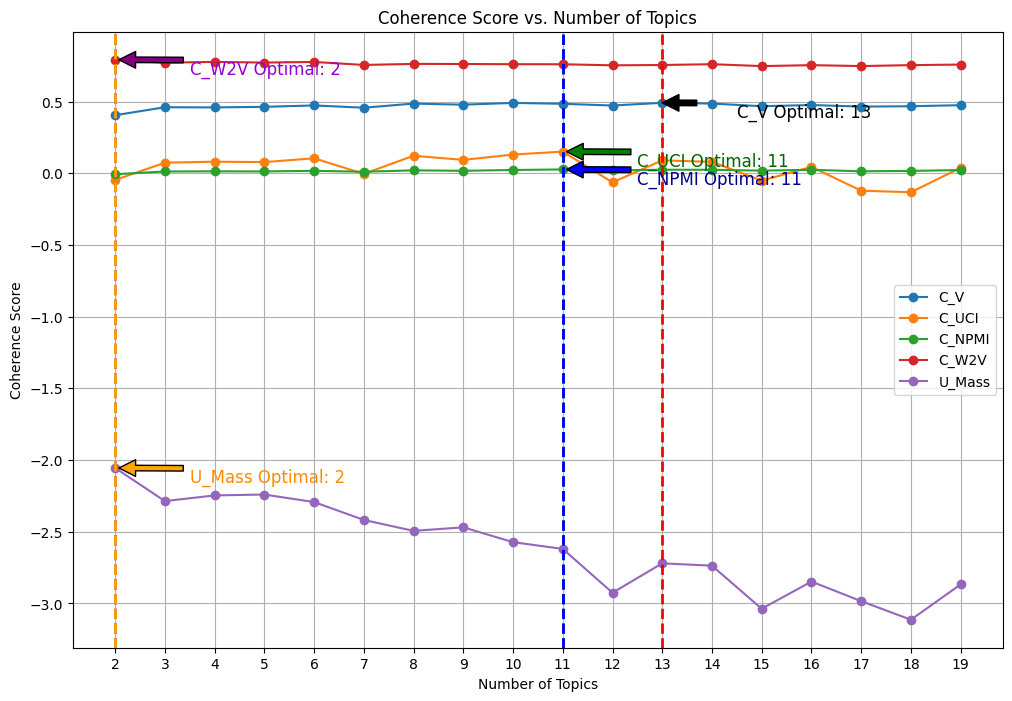

In [45]:
import matplotlib.pyplot as plt

x = list(range(2, 20))

plt.figure(figsize=(12, 8))

plt.plot(x, coherence_values_cv, label='C_V', marker='o')
plt.plot(x, coherence_values_uci, label='C_UCI', marker='o')
plt.plot(x, coherence_values_npmi, label='C_NPMI', marker='o')
plt.plot(x, coherence_values_w2v, label='C_W2V', marker='o')
plt.plot(x, coherence_values_umass, label='U_Mass', marker='o')  # Added U_Mass

plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.legend(loc='best')

# Highlight the optimal number of topics for each measure
optimal_num_topics_cv = x[coherence_values_cv.index(max(coherence_values_cv))]
optimal_num_topics_uci = x[coherence_values_uci.index(max(coherence_values_uci))]
optimal_num_topics_npmi = x[coherence_values_npmi.index(max(coherence_values_npmi))]
optimal_num_topics_w2v = x[coherence_values_w2v.index(max(coherence_values_w2v))]
optimal_num_topics_umass = x[coherence_values_umass.index(max(coherence_values_umass))]  # Added U_Mass

plt.axvline(x=optimal_num_topics_cv, color='r', linestyle='--', linewidth=2)
plt.annotate(f'C_V Optimal: {optimal_num_topics_cv}', xy=(optimal_num_topics_cv, max(coherence_values_cv)), 
             xytext=(optimal_num_topics_cv + 1.5, max(coherence_values_cv) - 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.5), fontsize=12, color='black', ha='left')

plt.axvline(x=optimal_num_topics_uci, color='g', linestyle='--', linewidth=2)
plt.annotate(f'C_UCI Optimal: {optimal_num_topics_uci}', xy=(optimal_num_topics_uci, max(coherence_values_uci)), 
             xytext=(optimal_num_topics_uci + 1.5, max(coherence_values_uci) - 0.1), 
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='darkgreen', ha='left')

plt.axvline(x=optimal_num_topics_npmi, color='b', linestyle='--', linewidth=2)
plt.annotate(f'C_NPMI Optimal: {optimal_num_topics_npmi}', xy=(optimal_num_topics_npmi, max(coherence_values_npmi)), 
             xytext=(optimal_num_topics_npmi + 1.5, max(coherence_values_npmi) - 0.1), 
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12, color='darkblue', ha='left')

plt.axvline(x=optimal_num_topics_w2v, color='purple', linestyle='--', linewidth=2)
plt.annotate(f'C_W2V Optimal: {optimal_num_topics_w2v}', xy=(optimal_num_topics_w2v, max(coherence_values_w2v)), 
             xytext=(optimal_num_topics_w2v + 1.5, max(coherence_values_w2v) - 0.1), 
             arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=12, color='darkviolet', ha='left')

plt.axvline(x=optimal_num_topics_umass, color='orange', linestyle='--', linewidth=2)  # Added U_Mass line
plt.annotate(f'U_Mass Optimal: {optimal_num_topics_umass}', xy=(optimal_num_topics_umass, max(coherence_values_umass)), 
             xytext=(optimal_num_topics_umass + 1.5, max(coherence_values_umass) - 0.1), 
             arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=12, color='darkorange', ha='left')

plt.xticks(range(2, 20))  # Set x-axis to display only integers
plt.grid(True)
plt.show()

In [7]:
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore

In [8]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=13,
                                           random_state=100,
                                           chunksize=400,  # Reduced chunk size
                                           passes=4,
                                           per_word_topics=True,
                                           workers=6)

In [8]:
def extract_topic_info(lda_model, corpus, dictionary, texts):
    topics_info = {}
    for i in range(optimal_num_topics):
        words = lda_model.show_topic(i, topn=10)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        
        # Calculate exclusivity (this is a simplistic version, usually exclusivity calculations are more involved)
        topic_words = [word for word, _ in words]
        all_other_topics_words = [lda_model.show_topic(j, topn=10) for j in range(optimal_num_topics) if j != i]
        all_other_words = [word for sublist in all_other_topics_words for word, _ in sublist]
        exclusivity_score = len(set(topic_words) - set(all_other_words)) / len(topic_words)
        
        topics_info[i] = {
            'Top Words and Probabilities': words,
            'Coherence Score': coherence_score,
            'Exclusivity Score': exclusivity_score,
            'Held-out Likelihood': lda_model.log_perplexity(corpus),
            'Topic Prevalence': sum([dict(doc).get(i, 0) for doc in corpus]) / len(corpus),
            'Semantic Interpretability': "High" if coherence_score > 0.5 and exclusivity_score > 0.5 else "Moderate"
        }
    
    return topics_info

In [11]:
topics_info = extract_topic_info(lda_model, corpus, dictionary, data)

In [12]:
# Display topics information
for topic_id, info in topics_info.items():
    print(f"Topic {topic_id + 1}:")
    for key, value in info.items():
        print(f"• {key}: {value}")
    print("\n")

Topic 1:
• Top Words and Probabilities: [('app', 0.051871028), ('match', 0.032088097), ('pay', 0.02287242), ('like', 0.016907526), ('time', 0.015788276), ('money', 0.013900054), ('premium', 0.013639564), ('free', 0.01240599), ('dating', 0.011403784), ('feature', 0.011127709)]
• Coherence Score: 0.5124105975282123
• Exclusivity Score: 0.2
• Held-out Likelihood: -7.487316437887833
• Topic Prevalence: 0.00016994391850689273
• Semantic Interpretability: Moderate


Topic 2:
• Top Words and Probabilities: [('woman', 0.042191654), ('first', 0.033375535), ('girl', 0.0270942), ('match', 0.024987172), ('guy', 0.024050422), ('app', 0.023454497), ('like', 0.020381777), ('make', 0.0122404555), ('one', 0.012168238), ('tinder', 0.012069335)]
• Coherence Score: 0.5124105975282123
• Exclusivity Score: 0.5
• Held-out Likelihood: -7.487300088092275
• Topic Prevalence: 0.012795777393460158
• Semantic Interpretability: Moderate


Topic 3:
• Top Words and Probabilities: [('like', 0.037034653), ('profile', 0

In [37]:
print("""Topic 1: Inapp Payments
Top Words and Probabilities: [('app', 0.05030042), ('match', 0.032709837), ('pay', 0.027241474), ('like', 0.018386435), ('time', 0.015914703), ('money', 0.01512026), ('premium', 0.013318833), ('profile', 0.013296554), ('free', 0.011519218), ('dating', 0.01122319)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.1
Held-out Likelihood: -7.4912914783359605
Topic Prevalence: 0.00016994391850689273
Semantic Interpretability: Moderate
Topic 2: User Interaction
Top Words and Probabilities: [('woman', 0.036016855), ('first', 0.030683829), ('girl', 0.026157115), ('match', 0.023809267), ('app', 0.023758769), ('like', 0.02074385), ('guy', 0.020121608), ('tinder', 0.014551743), ('bumble', 0.013427584), ('give', 0.0131116025)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.4
Held-out Likelihood: -7.491275048731727
Topic Prevalence: 0.012795777393460158
Semantic Interpretability: Moderate
Topic 3: Profile Quality
Top Words and Probabilities: [('like', 0.033014733), ('people', 0.024877265), ('app', 0.024259895), ('profile', 0.022341788), ('would', 0.01903647), ('question', 0.018357813), ('good', 0.01566998), ('match', 0.013891716), ('person', 0.011251582), ('see', 0.011179105)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.3
Held-out Likelihood: -7.491282803031789
Topic Prevalence: 0.007237611588175902
Semantic Interpretability: Moderate
Topic 4: Features
Top Words and Probabilities: [('like', 0.088557936), ('people', 0.03871144), ('see', 0.03483919), ('pay', 0.02689776), ('app', 0.022336204), ('match', 0.016733294), ('free', 0.01595426), ('liked', 0.013762478), ('away', 0.0111813545), ('tinder', 0.01009546)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.2
Held-out Likelihood: -7.491291188066838
Topic Prevalence: 0.7721152019833455
Semantic Interpretability: Moderate
Topic 5: Notification alerts
Top Words and Probabilities: [('message', 0.05652136), ('app', 0.04603908), ('match', 0.027948698), ('notification', 0.022719061), ('back', 0.018247925), ('time', 0.016343039), ('new', 0.0155723095), ('update', 0.013513175), ('fix', 0.012847895), ('give', 0.011662407)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.6
Held-out Likelihood: -7.491272870965244
Topic Prevalence: 0.08523187348175103
Semantic Interpretability: High
Topic 6: Subscription Payment Issues
Top Words and Probabilities: [('subscription', 0.0417806), ('app', 0.03222661), ('payment', 0.015224515), ('card', 0.013426661), ('cancel', 0.013124654), ('month', 0.012945986), ('money', 0.012475828), ('play', 0.009590212), ('option', 0.009327407), ('paid', 0.009075348)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.6
Held-out Likelihood: -7.49129516691765
Topic Prevalence: 0.0012895744404346566
Semantic Interpretability: High
Topic 7: Profile Matches
Top Words and Probabilities: [('swipe', 0.08055748), ('right', 0.06685581), ('left', 0.028721197), ('swiped', 0.023216672), ('swiping', 0.020807786), ('app', 0.019672832), ('profile', 0.019165656), ('time', 0.017815394), ('like', 0.016328357), ('people', 0.01567804)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.5
Held-out Likelihood: -7.491270005829409
Topic Prevalence: 0.005168294462827267
Semantic Interpretability: Moderate
Topic 8: Customer Support
Top Words and Probabilities: [('account', 0.047882397), ('banned', 0.0417232), ('reason', 0.0314016), ('app', 0.019236982), ('got', 0.017854031), ('support', 0.017218221), ('service', 0.01646238), ('tinder', 0.015317171), ('customer', 0.01412358), ('give', 0.011574125)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.5
Held-out Likelihood: -7.491255140950424
Topic Prevalence: 0.002709105995021643
Semantic Interpretability: Moderate
Topic 9: Profile Filtering
Top Words and Probabilities: [('app', 0.028939642), ('woman', 0.019749187), ('filter', 0.015995365), ('men', 0.014729411), ('people', 0.012490476), ('location', 0.012404767), ('looking', 0.011611819), ('option', 0.010654781), ('want', 0.010411659), ('age', 0.010317284)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.6
Held-out Likelihood: -7.491253077736938
Topic Prevalence: 0.023952095808383235
Semantic Interpretability: High
Topic 10: Fake Accounts
Top Words and Probabilities: [('account', 0.05722714), ('profile', 0.051169146), ('fake', 0.049143136), ('tinder', 0.015265087), ('app', 0.012706436), ('user', 0.011808739), ('delete', 0.011672535), ('bot', 0.010102692), ('instagram', 0.008689384), ('trying', 0.008560881)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.6
Held-out Likelihood: -7.491289373364252
Topic Prevalence: 0.009826757170133855
Semantic Interpretability: High
Topic 11: Subscription Model
Top Words and Probabilities: [('year', 0.028198881), ('tinder', 0.023921767), ('month', 0.021387234), ('due', 0.018814588), ('found', 0.018511685), ('ago', 0.018450854), ('app', 0.0153912455), ('got', 0.012400984), ('thanks', 0.010395425), ('day', 0.010007178)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.6
Held-out Likelihood: -7.4912808715940375
Topic Prevalence: 0.02096308218287965
Semantic Interpretability: High
Topic 12: Usability
Top Words and Probabilities: [('app', 0.07017291), ('work', 0.021273527), ('use', 0.018162018), ('photo', 0.017629482), ('time', 0.016775478), ('number', 0.015458605), ('tried', 0.013806329), ('casebook', 0.011681116), ('picture', 0.010959263), ('wont', 0.010804199)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.8
Held-out Likelihood: -7.491280058025006
Topic Prevalence: 0.38794197914688155
Semantic Interpretability: High
Topic 13: User Experience on Finding Matches,Meeting, and Dating
Top Words and Probabilities: [('app', 0.0634914), ('people', 0.0394976), ('dating', 0.03061986), ('good', 0.021287203), ('give', 0.018887809), ('love', 0.015683655), ('best', 0.014522459), ('great', 0.014481698), ('meet', 0.014165022), ('find', 0.0120145045)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.5
Held-out Likelihood: -7.491297470309195
Topic Prevalence: 0.2618635850169444
Semantic Interpretability: Moderate""")

Topic 1: Inapp Payments
Top Words and Probabilities: [('app', 0.05030042), ('match', 0.032709837), ('pay', 0.027241474), ('like', 0.018386435), ('time', 0.015914703), ('money', 0.01512026), ('premium', 0.013318833), ('profile', 0.013296554), ('free', 0.011519218), ('dating', 0.01122319)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.1
Held-out Likelihood: -7.4912914783359605
Topic Prevalence: 0.00016994391850689273
Semantic Interpretability: Moderate
Topic 2: User Interaction
Top Words and Probabilities: [('woman', 0.036016855), ('first', 0.030683829), ('girl', 0.026157115), ('match', 0.023809267), ('app', 0.023758769), ('like', 0.02074385), ('guy', 0.020121608), ('tinder', 0.014551743), ('bumble', 0.013427584), ('give', 0.0131116025)]
Coherence Score: 0.5017872334838134
Exclusivity Score: 0.4
Held-out Likelihood: -7.491275048731727
Topic Prevalence: 0.012795777393460158
Semantic Interpretability: Moderate
Topic 3: Profile Quality
Top Words and Probabilities: [('like', 0.033

In [38]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import pickle

# Function to map each review to the dominant topic and include topic name
def map_reviews_to_topics(lda_model, corpus, topics):
    reviews_topics = []
    for bow in corpus:
        topics_prob = lda_model.get_document_topics(bow)
        dominant_topic = max(topics_prob, key=lambda x: x[1])[0] + 1  # Adjust for 1-based indexing
        reviews_topics.append(topics[dominant_topic])
    return reviews_topics

# Manually create the topics dictionary with 1-based indexing
topics = {
    1: "Inapp Payments",
    2: "User Interaction",
    3: "Profile Quality",
    4: "Features",
    5: "Notification alerts",
    6: "Subscription Payment Issues",
    7: "Profile Matches",
    8: "Customer Support",
    9: "Profile Filtering",
    10: "Fake Accounts",
    11: "Subscription Model",
    12: "Usability",
    13: "User Experience on Finding Matches,Meeting, and Dating"
}

# Map each review to the dominant topic with names
df['Dominant_Topic'] = map_reviews_to_topics(lda_model, corpus, topics)

# Extract topic number from 'Dominant_Topic' for counting occurrences
df['Topic_Number'] = df['Dominant_Topic'].apply(lambda x: list(topics.values()).index(x) + 1)

# Count the occurrences of each topic
topic_counts = df['Topic_Number'].value_counts().sort_index()

# Calculate the percentage of documents for each topic
total_docs = len(df)
topic_percentages = (topic_counts / total_docs) * 100

# Create a DataFrame for the topic occurrence frequency analysis
topic_analysis_df = pd.DataFrame({
    'Topic': [topics[i] for i in range(1, len(topics) + 1)],
    'Count': topic_counts,
    'Percentage': topic_percentages
})

# Display the frequency analysis
print(topic_analysis_df)

# Save the results to a CSV file
topic_analysis_df.to_csv('topic_occurrence_frequency_analysis_2.csv', index=False)

# Save the DataFrame with topic mappings
df.to_csv('reviews_with_topic_mappings_2.csv', index=False)

print("Topic occurrence frequency analysis saved to 'topic_occurrence_frequency_analysis.csv'.")
print("Reviews with topic mappings saved to 'reviews_with_topic_mappings.csv'.")

                                                          Topic  Count  \
Topic_Number                                                             
1                                                Inapp Payments  10862   
2                                              User Interaction   8817   
3                                               Profile Quality   9808   
4                                                      Features   9837   
5                                           Notification alerts  10857   
6                                   Subscription Payment Issues   2906   
7                                               Profile Matches   1743   
8                                              Customer Support   8295   
9                                             Profile Filtering   5117   
10                                                Fake Accounts   2862   
11                                           Subscription Model   1570   
12                                    

In [16]:
import os
os.getcwd()

'/Users/karthikeyana'

In [9]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import numpy as np

# Sample 2000 reviews for each rating category (ensure there are at most 2000 reviews per category)
sampled_df = df.groupby('score').apply(lambda x: x.sample(n=min(len(x), 10000), random_state=1)).reset_index(drop=True)

# Tokenize the reviews
sampled_df['tokens'] = sampled_df['cleaned_review'].apply(lambda x: x.split())  # Assuming space-separated tokens

# Convert sampled reviews to corpus
sampled_corpus = [dictionary.doc2bow(tokens) for tokens in sampled_df['tokens']]

# Function to get topic probabilities for each review
def get_topic_probabilities(lda_model, corpus, num_topics):
    topic_probs = np.zeros((len(corpus), num_topics))
    for i, bow in enumerate(corpus):
        topics_prob = lda_model.get_document_topics(bow, minimum_probability=0)
        for topic_id, prob in topics_prob:
            topic_probs[i, topic_id] = prob
    return topic_probs

# Get the number of topics
num_topics = len(lda_model.get_topics())

# Get topic probabilities for the sampled reviews
topic_probs = get_topic_probabilities(lda_model, sampled_corpus, num_topics)

# Prepare the DataFrame for regression analysis
topic_columns = [f'Topic_{i+1}_Probability' for i in range(num_topics)]
topic_probs_df = pd.DataFrame(topic_probs, columns=topic_columns)

# Concatenate review text, rating, and topic probabilities
regression_df = pd.concat([sampled_df[['cleaned_review', 'score']], topic_probs_df], axis=1)

# Save the matrix to a CSV file
regression_df.to_csv('review_topic_probabilities_for_regression_2.csv', index=False)

print("Review-topic probabilities matrix for 10000 reviews per rating category saved to 'review_topic_probabilities_for_regression.csv'.")

/var/folders/xj/0f6j2h1s4mg19smjqbvwpfkh0000gn/T/ipykernel_9199/210162555.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('score').apply(lambda x: x.sample(n=min(len(x), 10000), random_state=1)).reset_index(drop=True)


Review-topic probabilities matrix for 10000 reviews per rating category saved to 'review_topic_probabilities_for_regression.csv'.


In [10]:
print(regression_df.head())

                                      cleaned_review  score  \
0  awful not pay get none interest not waist time...      1   
1  bumble not care get date want money played app...      1   
2  absolute scam bought boost thing one time thin...      1   
3  cant view profile deleted reinstalled app fixe...      1   
4  time app suck free like dating app free litera...      1   

   Topic_1_Probability  Topic_2_Probability  Topic_3_Probability  \
0             0.452287             0.004527             0.004527   
1             0.548437             0.003079             0.003079   
2             0.319873             0.004525             0.004525   
3             0.002138             0.002138             0.002138   
4             0.507988             0.001833             0.001833   

   Topic_4_Probability  Topic_5_Probability  Topic_6_Probability  \
0             0.004527             0.004527             0.004527   
1             0.003079             0.003079             0.003079   
2       

In [12]:
import statsmodels.api as sm
import pandas as pd

In [40]:
# Load the previously saved matrix
regression_df = pd.read_excel('df2_data_with_regression_2.xlsx')

# Define the dependent variable (Rating/Score)
y = regression_df['score']

# Define the independent variables (Topic Probabilities)
X = regression_df.drop(columns=['cleaned_review','score'])

# Add a constant term for the intercept
X = sm.add_constant(X)

# Perform OLS regression
model = sm.OLS(y, X).fit()

# Get the regression results
regression_results = model.summary2().tables[1]

# Display the results
print(regression_results)

# Save the results to a CSV file
regression_results.to_csv('ols_regression_results_2.csv')

print("OLS regression results saved to 'ols_regression_results.csv'.")

                                                        Coef.  Std.Err.  \
const                                                2.791191  0.004593   
In-app Payments                                     -2.008806  0.103299   
User Interaction                                    -4.019202  0.103169   
Profile Quality                                     10.903477  0.102758   
Features                                            -3.235694  0.103014   
Notification Alerts                                 -2.787992  0.102561   
Subscription Payment Issues                         -3.487205  0.103316   
Profile Matches                                      9.006006  0.103322   
Customer Support                                    -1.344003  0.102510   
Profile Filtering                                   -3.667337  0.102590   
Fake Accounts                                       -3.192067  0.103120   
Subscription Model                                  -3.021744  0.103931   
Usability                

In [41]:
results = model.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     2653.
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:42:25   Log-Likelihood:                -75955.
No. Observations:               50000   AIC:                         1.519e+05
Df Residuals:                   49987   BIC:                         1.521e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [42]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming 'X' is the matrix of topic probabilities and 'y' is the score (rating)
# Fit the full model
model = LinearRegression()
model.fit(X, y)
full_model_r2 = r2_score(y, model.predict(X))

# Initialize a dictionary to store dominance results
dominance_results = {}

# Loop through each predictor to calculate partial R-squared
for predictor in X.columns:
    remaining_predictors = [col for col in X.columns if col != predictor]
    partial_model = LinearRegression()
    partial_model.fit(X[remaining_predictors], y)
    partial_r2 = r2_score(y, partial_model.predict(X[remaining_predictors]))
    dominance_results[predictor] = full_model_r2 - partial_r2

# Convert dominance results to percentage importance
total_dominance = sum(dominance_results.values())
relative_importance = {k: (v / total_dominance) * 100 for k, v in dominance_results.items()}

# Sort predictors by their relative importance
sorted_importance = sorted(relative_importance.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame for the table
dominance_df = pd.DataFrame(sorted_importance, columns=["Topic Name", "% Importance"])

# Add Topic Serial Number
dominance_df["Topic Serial Number"] = ["Topic {}".format(i + 1) for i in range(len(dominance_df))]

# Reorder columns
dominance_df = dominance_df[["Topic Serial Number", "Topic Name", "% Importance"]]

# Display the table
print(dominance_df)

# Optionally, save the table to a CSV file
dominance_df.to_csv('dominance_analysis_results.csv', index=False)

   Topic Serial Number                                         Topic Name  \
0              Topic 1                                    In-app Payments   
1              Topic 2                                   User Interaction   
2              Topic 3                                    Profile Quality   
3              Topic 4                                           Features   
4              Topic 5                                Notification Alerts   
5              Topic 6                        Subscription Payment Issues   
6              Topic 7                                    Profile Matches   
7              Topic 8                                   Customer Support   
8              Topic 9                                  Profile Filtering   
9             Topic 10                                      Fake Accounts   
10            Topic 11                                 Subscription Model   
11            Topic 12                                          Usability   

In [43]:
dominance_df

,Topic Serial Number,Topic Name,% Importance
0,Topic 1,In-app Payments,8.17
1,Topic 2,User Interaction,5.08
2,Topic 3,Profile Quality,10.79
3,Topic 4,Features,6.42
4,Topic 5,Notification Alerts,6.01
5,Topic 6,Subscription Payment Issues,3.02
6,Topic 7,Profile Matches,7.62
7,Topic 8,Customer Support,7.84
8,Topic 9,Profile Filtering,4.55
9,Topic 10,Fake Accounts,6.71


In [44]:
import pandas as pd

# Assuming 'regression_df' has the structure: 'Review_Text', 'score', 'Topic_1_Probability', ..., 'Topic_13_Probability'

# Create a list to store the topic labels (1-13)
topic_labels = ['In-app Payments','User Interaction','Profile Quality','Features','Notification Alerts','Subscription Payment Issues','Profile Matches','Customer Support','Profile Filtering','Fake Accounts','Subscription Model','Usability','User Experience on Finding Matches,Meeting, and Dating']

# Sum up the probabilities for each topic, grouped by 'score'
topic_rating = regression_df.groupby('score')[topic_labels].mean()

# Display the 'topic_rating' DataFrame
print(topic_rating)

# Save 'topic_rating' to a CSV file if needed
topic_rating.to_csv('topic_rating_2.csv')


       In-app Payments  User Interaction  Profile Quality  Features  \
score                                                                 
1             0.080909          0.086667         0.052578  0.084203   
2             0.078745          0.080313         0.067564  0.079943   
3             0.077417          0.076368         0.076436  0.077756   
4             0.074595          0.074131         0.085396  0.073140   
5             0.072931          0.067244         0.101265  0.068515   

       Notification Alerts  Subscription Payment Issues  Profile Matches  \
score                                                                      
1                 0.085124                     0.086771         0.057592   
2                 0.081308                     0.079534         0.068055   
3                 0.077507                     0.076613         0.075209   
4                 0.075130                     0.074494         0.085530   
5                 0.069832                    

In [45]:
topic_rating_t=topic_rating.T
topic_rating_t

score,1,2,3,4,5
In-app Payments,0.080909,0.078745,0.077417,0.074595,0.072931
User Interaction,0.086667,0.080313,0.076368,0.074131,0.067244
Profile Quality,0.052578,0.067564,0.076436,0.085396,0.101265
Features,0.084203,0.079943,0.077756,0.073140,0.068515
Notification Alerts,0.085124,0.081308,0.077507,0.075130,0.069832
Subscription Payment Issues,0.086771,0.079534,0.076613,0.074494,0.069799
Profile Matches,0.057592,0.068055,0.075209,0.085530,0.096356
Customer Support,0.081026,0.078705,0.075143,0.075310,0.074538
Profile Filtering,0.085473,0.079728,0.076936,0.073440,0.068426
Fake Accounts,0.085242,0.078610,0.077617,0.074275,0.068933


In [46]:
import pandas as pd
import prince
import matplotlib.pyplot as plt
import pandas as pd
import prince
import matplotlib.pyplot as plt
topic_rating_c = topic_rating_t.copy()


Correspondence analysis results saved to 'topic_rating_with_ca.csv'.


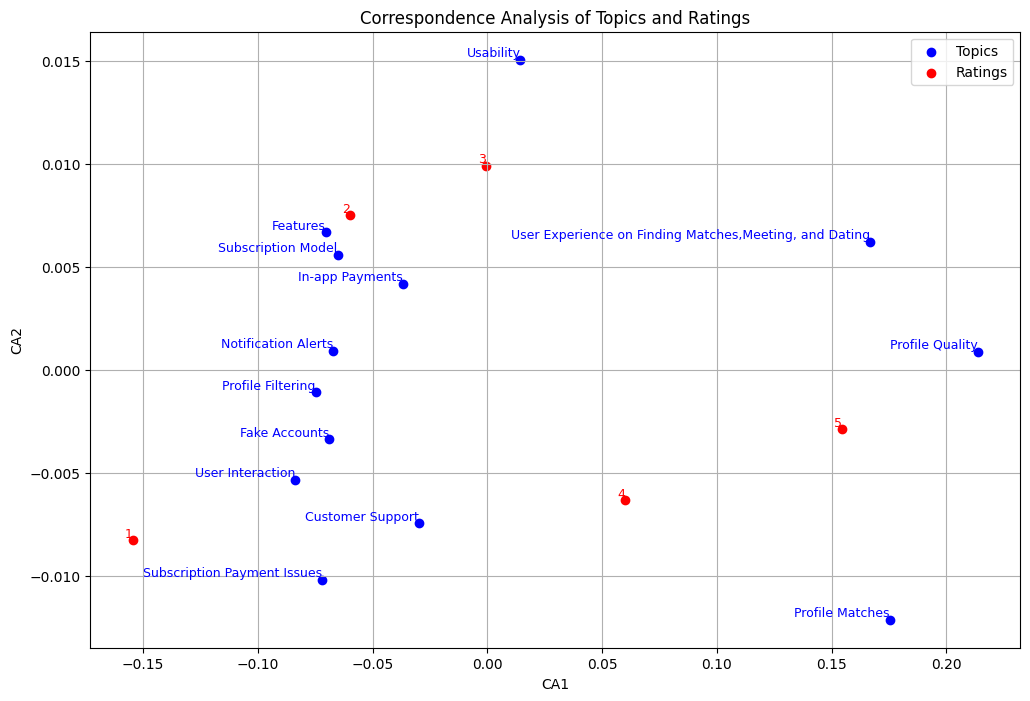

In [47]:

# Initialize Correspondence Analysis
ca = prince.CA(n_components=2)

# Fit the model
ca = ca.fit(topic_rating_c)

# Get the coordinates of the rows and columns
row_coordinates = ca.row_coordinates(topic_rating_c)
column_coordinates = ca.column_coordinates(topic_rating_c)

# Add the transformed data to the DataFrame for visualization
topic_rating_c['CA1'] = row_coordinates.iloc[:, 0]
topic_rating_c['CA2'] = row_coordinates.iloc[:, 1]

# Save the result
topic_rating_c.to_csv('topic_rating_with_ca.csv')

print("Correspondence analysis results saved to 'topic_rating_with_ca.csv'.")



# Plotting
plt.figure(figsize=(12, 8))

# Plot topic coordinates
plt.scatter(row_coordinates.iloc[:, 0], row_coordinates.iloc[:, 1], color='blue', label='Topics')
for i, txt in enumerate(row_coordinates.index):
    plt.text(row_coordinates.iloc[i, 0], row_coordinates.iloc[i, 1], txt, fontsize=9, color='blue', ha='right', va='bottom')

# Plot rating coordinates
plt.scatter(column_coordinates.iloc[:, 0], column_coordinates.iloc[:, 1], color='red', label='Ratings')
for i, txt in enumerate(column_coordinates.index):
    plt.text(column_coordinates.iloc[i, 0], column_coordinates.iloc[i, 1], txt, fontsize=9, color='red', ha='right', va='bottom')

# Labeling
plt.xlabel(f'CA1')
plt.ylabel(f'CA2')
plt.title('Correspondence Analysis of Topics and Ratings')

# Add legend
plt.legend(loc='best')

# Show plot
plt.grid(True)
plt.show()